# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

sns.set_style('dark')


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from torchvision import transforms

from unet import UNet
from torchinfo import summary

In [14]:
data_path = os.path.join('.', 'data')

train_path = os.path.join(data_path, 'train', 'train')
val_path = os.path.join(data_path, 'validation')
test_path = os.path.join(data_path, 'test', 'test')

In [15]:
def show_images(ct,dose,possible_dose_mask,structure_masks,sample_idx=0,**kwargs):

        structure_masks = structure_masks.squeeze(0)
        fig, ax = plt.subplots(2, 2)
        ax = ax.flatten()
        ax[0].imshow(ct.squeeze(), cmap='gray', vmin=0, vmax=ct.max())
        ax[0].set_title('CT')
        ax[1].imshow(dose.squeeze())
        ax[1].set_title('Dose')
        ax[2].imshow(possible_dose_mask.squeeze())
        ax[2].set_title('Possible dose mask')
        for organ in structure_masks:
            ax[3].imshow(organ)
        ax[3].set_title('Structure masks')

        for axis in ax:
            axis.axis('off')

        plt.tight_layout()
        plt.suptitle('Sample '+str(sample_idx))
        plt.show()

In [16]:
def show_random_images(path,n):
    id_exs = np.random.randint(0, 7799,n)
    for id_ex in id_exs:
        sample_path = os.path.join(path, 'sample_'+str(id_ex))
        ct_path = os.path.join(sample_path, 'ct.npy')
        dose_path = os.path.join(sample_path, 'dose.npy')
        possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
        structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

        ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
        dose = torch.from_numpy(np.load(dose_path)).unsqueeze(0)
        possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
        structure_masks = torch.from_numpy(np.load(structure_masks_path)).unsqueeze(0)
        

        show_images(ct,dose,possible_dose_mask,structure_masks,sample_idx=id_ex)

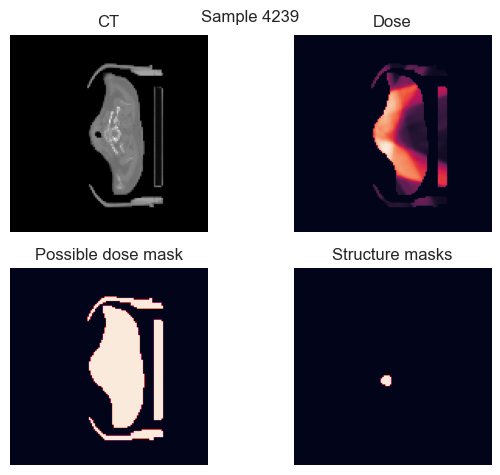

In [17]:
show_random_images(train_path, 1)

In [18]:
#Manual load of a sample
id_ex = 0
sample_path = os.path.join(train_path, 'sample_'+str(id_ex))
ct_path = os.path.join(sample_path, 'ct.npy')
dose_path = os.path.join(sample_path, 'dose.npy')
possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
dose = torch.from_numpy(np.load(dose_path)).unsqueeze(0)
possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
structure_masks = torch.from_numpy(np.load(structure_masks_path))


# Dataset

In [19]:
from datasetsDLMI import DLMI_Train, DLMI_Test

In [20]:
mean_ct = np.load(os.path.join(data_path, 'mean_ct.npy'))
std_ct = np.load(os.path.join(data_path, 'std_ct.npy'))
mean_dose = np.load(os.path.join(data_path, 'mean_dose.npy'))
std_dose = np.load(os.path.join(data_path, 'std_dose.npy'))

In [21]:
print(
    'mean_ct: ', mean_ct,
    'std_ct: ', std_ct,
    'mean_dose: ', mean_dose,
    'std_dose: ', std_dose
)

mean_ct:  97.59464646559495 std_ct:  298.82489850204036 mean_dose:  2.945620140701685 std_dose:  10.749361438151379


In [22]:
def compute_mean_std(loader):
    mean_ct = 0.
    std_ct = 0.

    mean_dose = 0.
    std_dose = 0.
    nb_samples = 0.

    for (ct, _, _), dose in tqdm(loader):
        batch_samples = ct.size(0)

        ct = ct.view(batch_samples, ct.size(1), -1)
        dose = dose.view(batch_samples, dose.size(1), -1)

        mean_ct += ct.mean((1,2)).sum(0)
        std_ct += ct.std((1,2)).sum(0)

        mean_dose += dose.mean((1,2)).sum(0)
        std_dose += dose.std((1,2)).sum(0)

        nb_samples += batch_samples

    mean_ct /= nb_samples
    std_ct /= nb_samples

    mean_dose /= nb_samples
    std_dose /= nb_samples

    print(f"{mean_ct=}, {std_ct=}, {mean_dose=}, {std_dose=}")
    return mean_ct, std_ct, mean_dose, std_dose

In [23]:
# vanilla_train = DLMI_Train(train_path,ct_transform=None,dose_transform=None)
# vanilla_train_loader = DataLoader(vanilla_train, batch_size=1, shuffle=False, num_workers=0)
# mean_ct, std_ct, mean_dose, std_dose = compute_mean_std(vanilla_train_loader)
# # Save these values
# data_path = os.path.join('.', 'data')
# np.save(os.path.join(data_path, 'mean_ct.npy'), mean_ct)
# np.save(os.path.join(data_path, 'std_ct.npy'), std_ct)
# np.save(os.path.join(data_path, 'mean_dose.npy'), mean_dose)
# np.save(os.path.join(data_path, 'std_dose.npy'), std_dose)

# Architecture

# Setting of the training

In [24]:
num_workers = 0
lr = 1e-3
batch_size = 16
num_epochs = 100
gpu = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
exp_dir = os.path.join('.', 'exp2')
os.makedirs(exp_dir, exist_ok=True)

In [25]:
from augmentations import ct_transform,aug_transform,test_transform

train_dataset = DLMI_Train(train_path, ct_transform, aug_transform)
val_dataset = DLMI_Train(val_path, ct_transform)
test_dataset = DLMI_Test(test_path, test_transform)

In [26]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7800
Val dataset size: 1200
Test dataset size: 1200


In [27]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [28]:
print("Number of batches in train loader: ", len(train_loader))
print("Number of batches in val loader: ", len(val_loader))
print("Number of batches in test loader: ", len(test_loader))

Number of batches in train loader:  488
Number of batches in val loader:  75
Number of batches in test loader:  75


In [29]:
model = UNet( n_channels=12, n_classes=1)

In [30]:
# col_names = ['input_size', 'output_size', 'num_params']
summary(model, input_size=(1,12, 128, 128), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─ConvBatchNorm: 1-1                     [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         6,976
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         --
├─DownBlock: 1-2                         [1, 128, 64, 64]          --
│    └─MaxPool2d: 2-4                    [1, 64, 64, 64]           --
│    └─Sequential: 2-5                   [1, 128, 64, 64]          --
│    │    └─ConvBatchNorm: 3-1           [1, 128, 64, 64]          74,112
│    │    └─ConvBatchNorm: 3-2           [1, 128, 64, 64]          147,840
├─DownBlock: 1-3                         [1, 256, 32, 32]          --
│    └─MaxPool2d: 2-6                    [1, 128, 32, 32]          --
│    └─Sequential: 2-7                   [1, 256, 32, 32]          --
│ 

In [31]:
# optimizer = optim.SGD(model.parameters(), lr=lr)
# criterion = nn.L1Loss() # Mean Absolute Error

In [32]:
# model = model.to(device)

In [33]:
# train_one_epoch(model, optimizer, criterion, train_loader, "cuda")
# torch.save(model.state_dict(), 'model.pth')

In [34]:
# os.makedirs(exp_dir, exist_ok=True)
# state = dict(
#     epoch= 1,
#     model=model.state_dict(),
#     optimizer=optimizer.state_dict(),
# )
# save_path = os.path.join(exp_dir, 'model.pth')
# torch.save(state, save_path)

# Load model

In [48]:
exp_dir = os.path.join('.', 'exp3')
model = UNet( n_channels=12, n_classes=1)
optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)
gpu =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(gpu)

cuda:0


In [49]:
load_path = os.path.join(exp_dir, 'model.pth')
ckpt = torch.load(load_path, map_location="cpu")
start_epoch = ckpt["epoch"]
model.load_state_dict(ckpt["model"])
model = model.to(gpu)
optimizer.load_state_dict(ckpt["optimizer"])

In [50]:
#Make a prediction on the train/val set
def predict(model, loader, device,n_preds=1):
    ''' Predicts the output of the model on the given dataset loader
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to predict on
    loader : torch.utils.data.DataLoader
        The dataloader containing the dataset to predict on
    device : torch.device
        The device to run the model on
    n_preds : int
        The number of batches to go through. Default is 1

    Returns
    -------
    input : np.ndarray
        The input to the model. Shape (n_preds*batch_size, 12, 128, 128)
    preds : np.ndarray
        The predictions of the model. Shape (n_preds*batch_size, 1, 128, 128)
    ground_truth : np.ndarray
        The ground truth of the model. Shape (n_preds*batch_size, 1, 128, 128)
    '''
    model.eval()

    with torch.no_grad():
        seen = 0
        pbar = tqdm(loader, total=n_preds)
        for batch_idx,(x,y,idx) in enumerate(pbar):
            x = x.to(device).float()

            output = model(x)
            output = output.cpu().numpy()

            if batch_idx == 0:
                input = x.cpu().numpy()
                preds = output
                ground_truth = y.numpy()
            else:
                preds = np.concatenate((preds, output), axis=0)
                ground_truth = np.concatenate((ground_truth, y.numpy()), axis=0)
                input = np.concatenate((input, x.cpu().numpy()), axis=0)

            seen += 1

            if seen >= n_preds:
                # Set the pbdar to 100% to make sure it is done
                print("Done")
                break

    return input,preds, ground_truth

In [51]:
input,preds,ground_truth = predict(model, train_loader, gpu, n_preds=75)

 99%|█████████▊| 74/75 [01:53<00:01,  1.53s/it]

Done


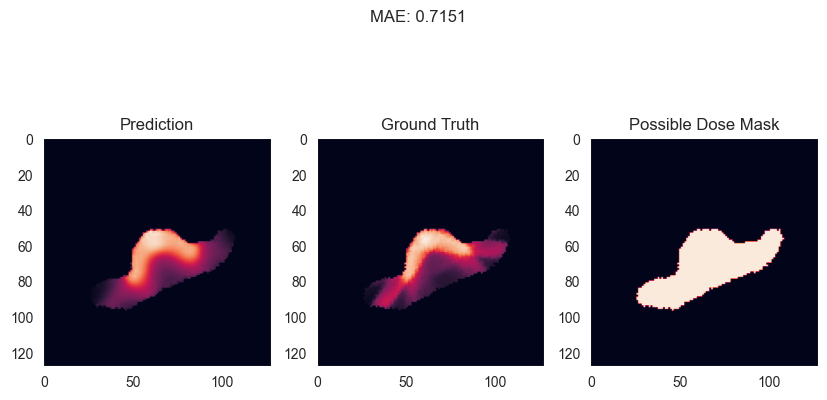

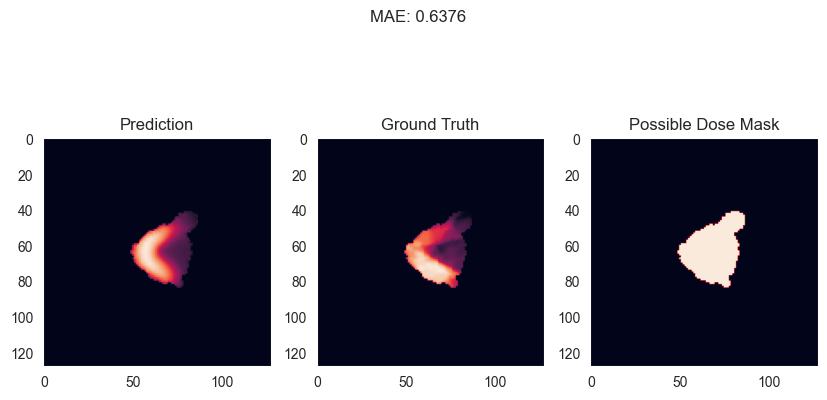

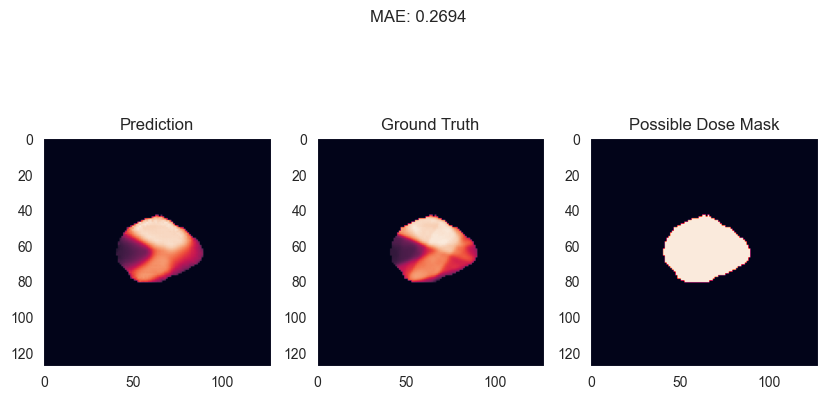

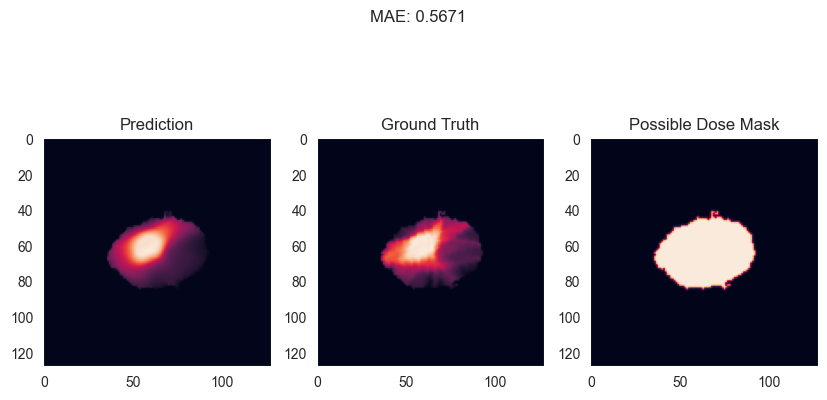

In [52]:
nb_to_show = np.min([preds.shape[0], 4])

rand_idx = np.random.choice(np.arange(preds.shape[0]), nb_to_show, replace=False)

for i in rand_idx:
    pred_model = preds[i].squeeze()
    gt = ground_truth[i].squeeze()
    possible_dose_mask = input[i,1].squeeze()

    pred = np.where(possible_dose_mask, pred_model, 0)

    mae = np.mean(np.abs(pred - gt))

    fig, ax = plt.subplots(1,3, figsize=(10,5))
    ax[0].imshow(pred)
    ax[0].set_title("Prediction")
    ax[1].imshow(gt)
    ax[1].set_title("Ground Truth")
    ax[2].imshow(possible_dose_mask)
    ax[2].set_title("Possible Dose Mask")
    plt.suptitle(f"MAE: {mae:.4f}")
    plt.show()


## Worst results

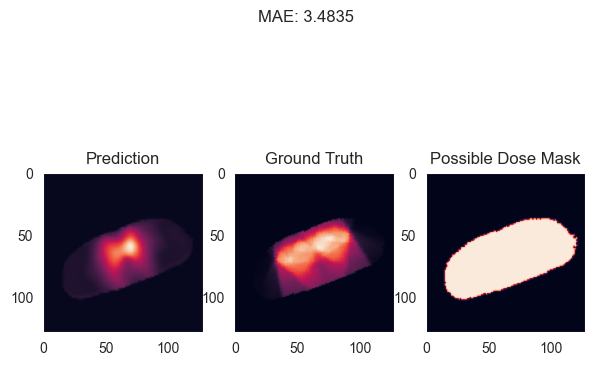

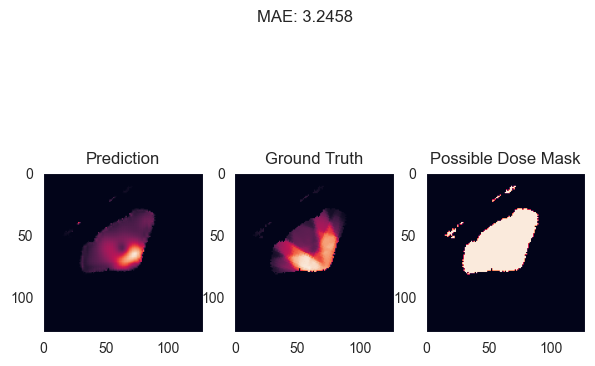

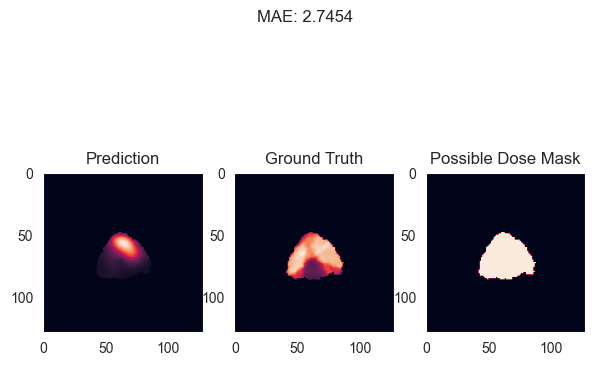

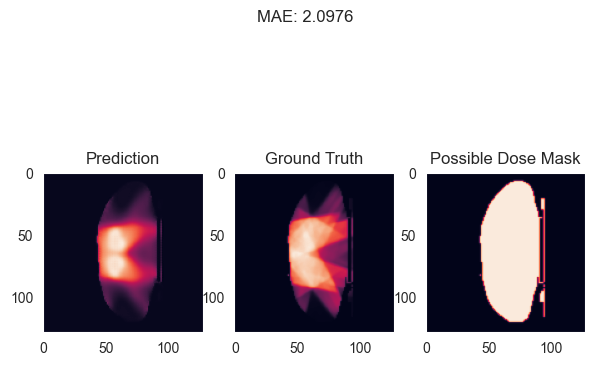

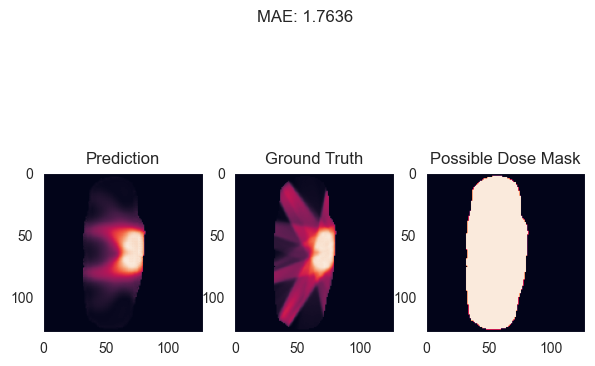

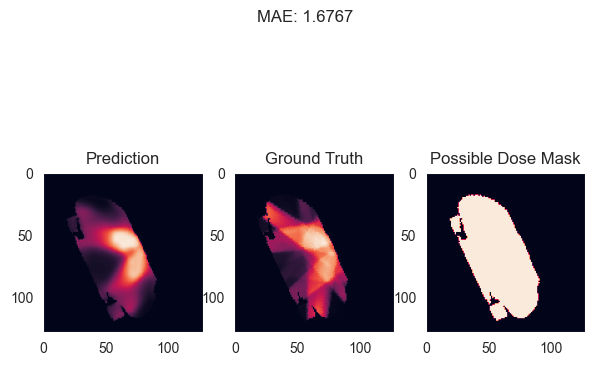

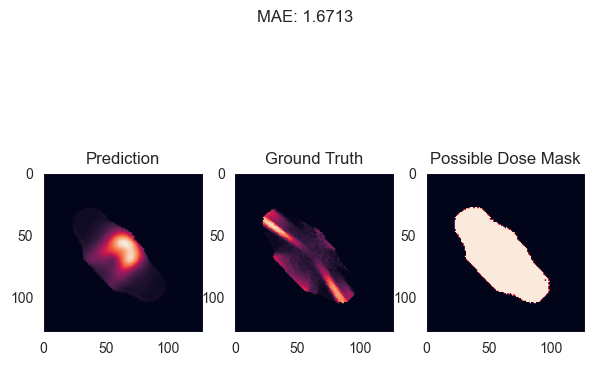

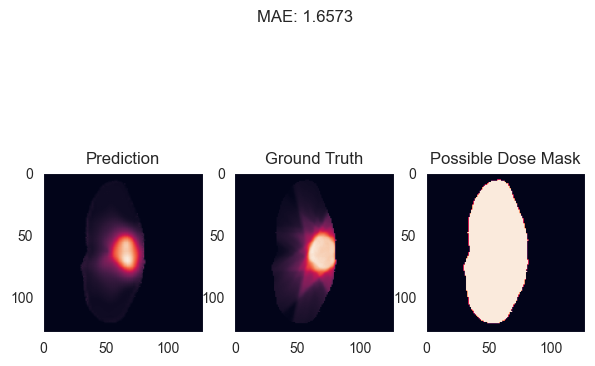

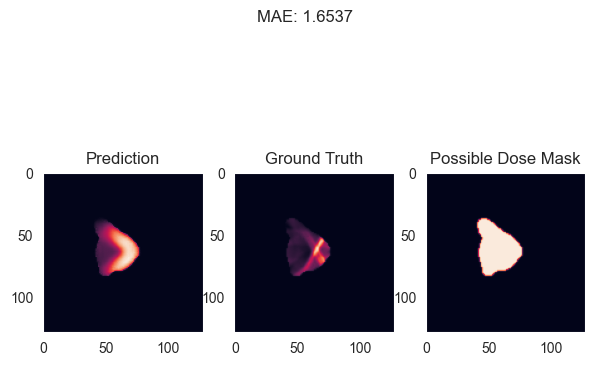

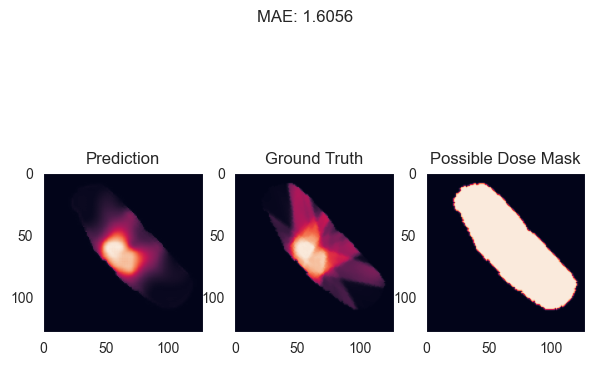

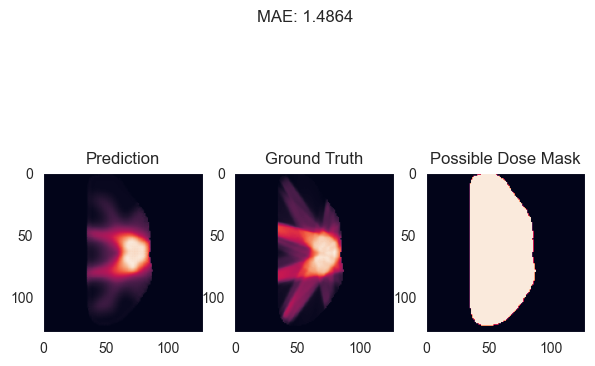

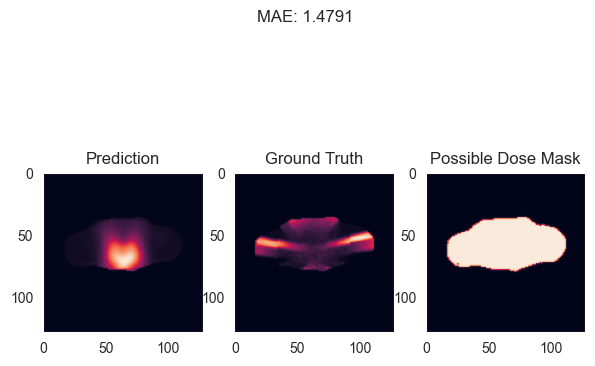

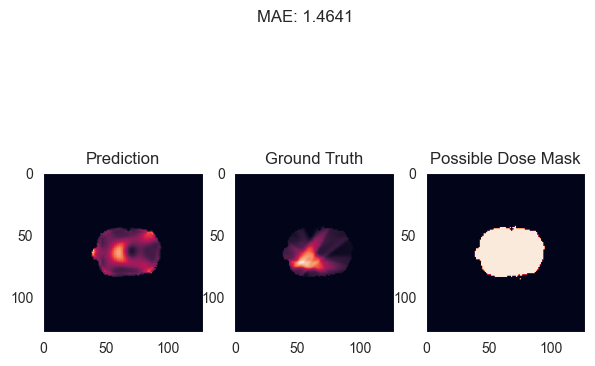

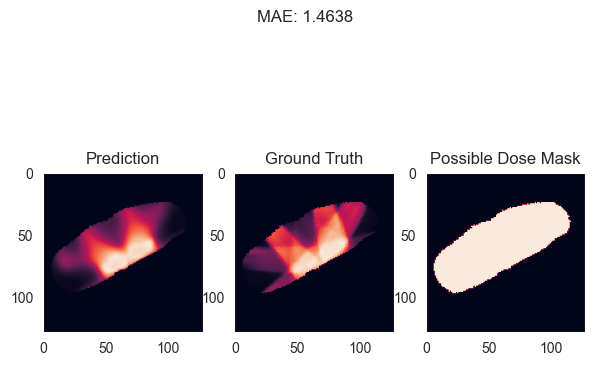

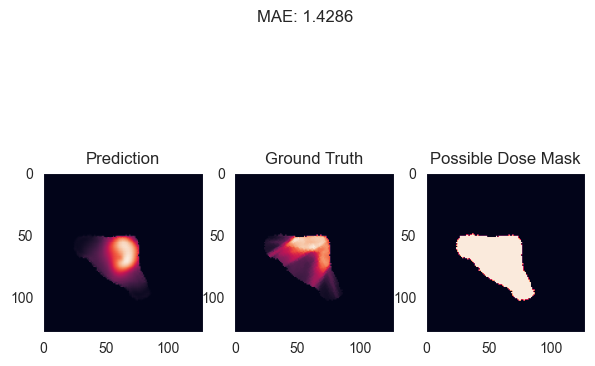

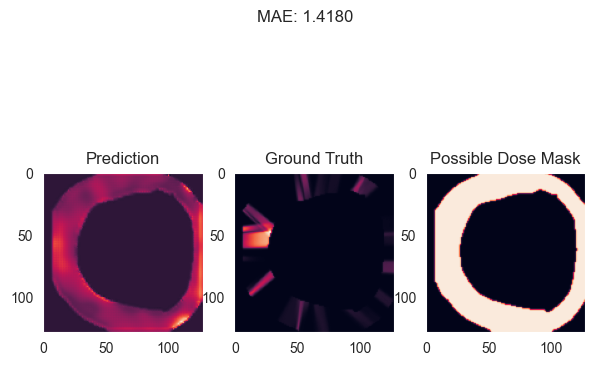

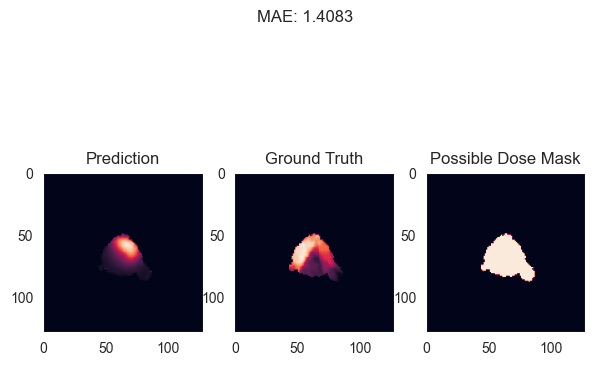

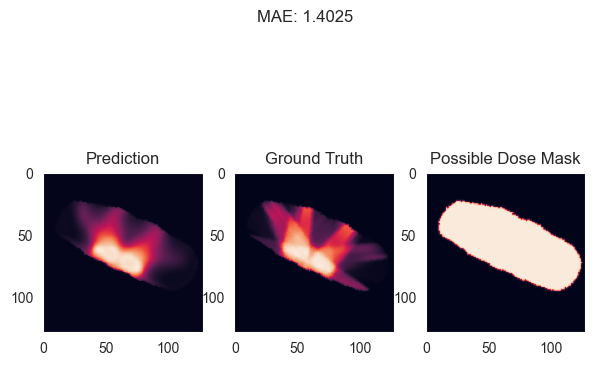

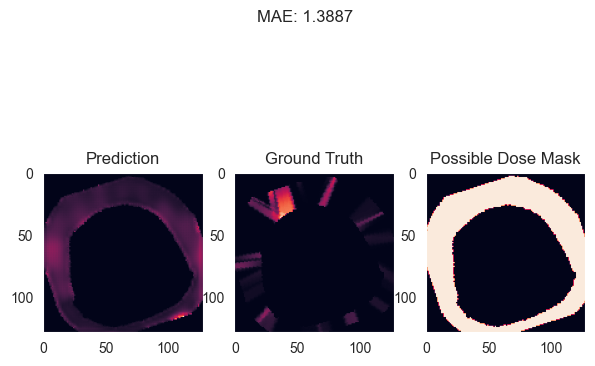

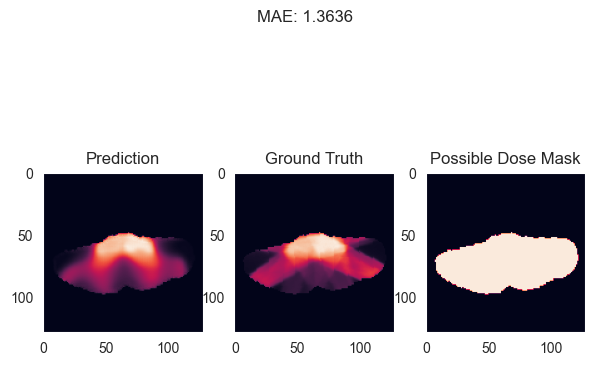

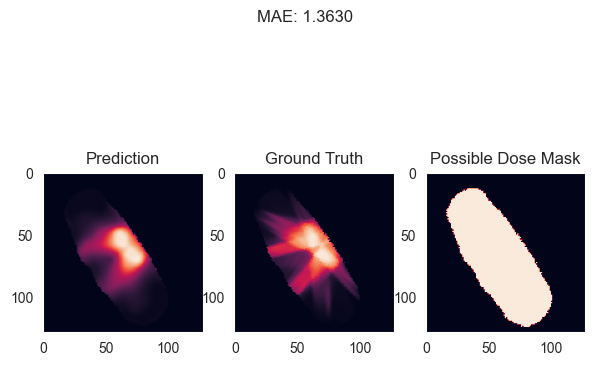

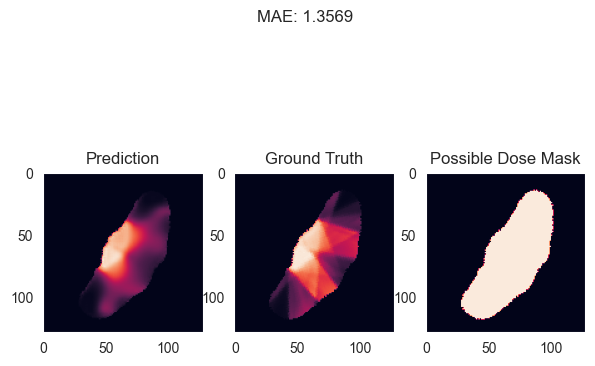

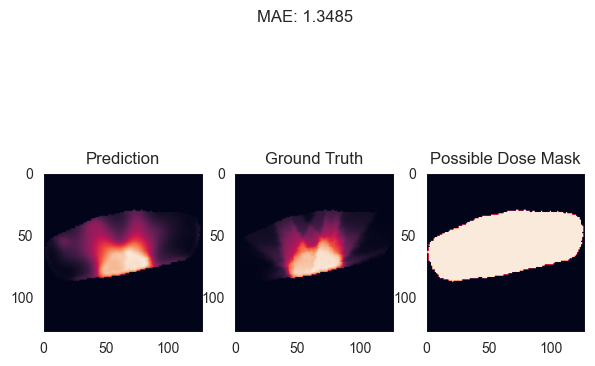

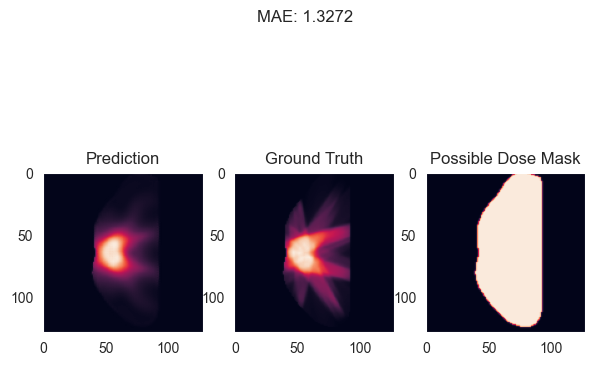

In [53]:
n_val = len(input)
mae = np.zeros(n_val)

for i in range(n_val):
    pred_model = preds[i].squeeze()
    gt = ground_truth[i].squeeze()
    possible_dose_mask = input[i,1].squeeze()

    pred = np.where(possible_dose_mask, pred_model, 0)

    mae[i] = np.mean(np.abs(pred - gt))

worst_idx = np.argsort(-mae)[: int(0.02 * n_val)]
for idx in worst_idx :
  pred_model = preds[idx].squeeze()
  gt = ground_truth[idx].squeeze()
  possible_dose_mask = input[idx,1].squeeze()

  pred = np.where(possible_dose_mask, pred_model, 0)

  mae_value = mae[idx] 

  fig, ax = plt.subplots(1,3, figsize=(7,5))
  ax[0].imshow(pred)
  ax[0].set_title("Prediction")
  ax[1].imshow(gt)
  ax[1].set_title("Ground Truth")
  ax[2].imshow(possible_dose_mask)
  ax[2].set_title("Possible Dose Mask")
  plt.suptitle(f"MAE: {mae_value:.4f}")
  plt.show()

In [80]:
def get_organ_repartition(dataset):
    n = len(dataset)
    repartition = np.zeros(10)
    for i in tqdm(range(n)):
        data = dataset[i]
        summed = data[0][2:].sum(axis=(1,2)).numpy()
        repartition += summed>0
    repartition = {k:np.round(v/n, 2) for k,v in enumerate(repartition)}
    return repartition

In [81]:
train_repart = get_organ_repartition(train_dataset)
val_repart = get_organ_repartition(val_dataset)
test_repart = get_organ_repartition(test_dataset)

print(pd.DataFrame([train_repart, val_repart, test_repart], index=['train', 'val', 'test']))

 70%|██████▉   | 835/1200 [01:12<00:31, 11.49it/s]


ValueError: cannot reshape array of size 0 into shape (128,128)

In [ ]:
from main import validate_one_epoch
criterion = nn.L1Loss() # Mean Absolute Error
loss = validate_one_epoch(model, ckpt["epoch"], criterion, val_loader, gpu)

Epoch 100: 100%|██████████| 75/75 [00:12<00:00,  5.78it/s, Loss 0.2145 - Loss_val_epoch 0.3976]


In [87]:
for i, (x,y,idx) in enumerate(val_loader):
    x = x.to(gpu).float()
    y = y.to(gpu).float()
    output = model(x)
    output = output
    break

In [100]:
a = torch.tensor([[1.,2.,1.],
                  [0,0,0],
                  [-1.,-2.,-1.]], requires_grad=False)
b = torch.tensor([[1.,0,-1.],
                  [2.,0,-2.],
                  [1.,0,-1.]], requires_grad=False)

a = a.unsqueeze(0).unsqueeze(0).requires_grad_(False)
b = b.unsqueeze(0).unsqueeze(0)
conv_hor = nn.Conv2d(1, 1, 3, padding=1, bias=False)
conv_hor.weight = nn.Parameter(a).requires_grad_(False)
conv_ver = nn.Conv2d(1, 1, 3, padding=1, bias=False)
conv_ver.weight = nn.Parameter(b).requires_grad_(False)

In [108]:
batch,y,idx = next(iter(train_loader))
output = model(batch.to(gpu).float())

In [127]:
conved_hor = conv_hor(output.to("cpu"))
conved_ver = conv_ver(output.to("cpu"))
grad = torch.sqrt(torch.square(conved_hor) + torch.square(conved_ver))

In [130]:
grad.sum()

tensor(811518.3125, grad_fn=<SumBackward0>)

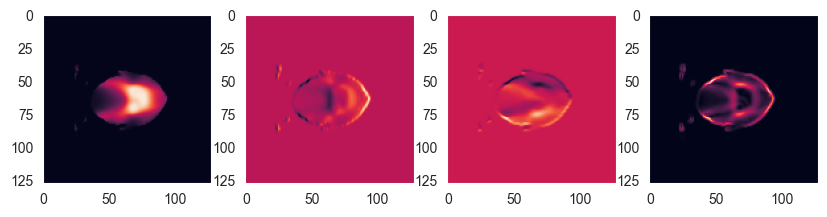

In [128]:
fig,ax = plt.subplots(1,4, figsize=(10,5))
ax[0].imshow(output[0,0,:,:].to('cpu').detach().numpy())
ax[1].imshow(conved_ver[0,0,:,:].to('cpu').detach().numpy())
ax[2].imshow(conved_hor[0,0,:,:].to('cpu').detach().numpy())
ax[3].imshow(grad[0,0,:,:].to('cpu').detach().numpy())

In [ ]:
class Gradient(nn.Module):
    def __init__(self) -> None:
        '''
        Computes the gradient of an image
        '''
        super().__init__()
        self.conv_hor = nn.Conv2d(1, 1, 3, padding=1, bias=False)
        self.conv_ver = nn.Conv2d(1, 1, 3, padding=1, bias=False)
        a = torch.tensor([[1.,2.,1.],
                            [0,0,0],
                            [-1.,-2.,-1.]], requires_grad=False)
        b = torch.tensor([[1.,0,-1.],
                            [2.,0,-2.],
                            [1.,0,-1.]], requires_grad=False)
        a = a.unsqueeze(0).unsqueeze(0).requires_grad_(False)
        b = b.unsqueeze(0).unsqueeze(0)
        self.conv_hor.weight = nn.Parameter(a).requires_grad_(False)
        self.conv_ver.weight = nn.Parameter(b).requires_grad_(False)

    def forward(self, x):
        conved_hor = self.conv_hor(x)
        conved_ver = self.conv_ver(x)
        grad = torch.sqrt(torch.square(conved_hor) + torch.square(conved_ver))
        return grad

# Examine training 

In [131]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

exp_dir = os.path.join('.', 'exp3')
stats_path = os.path.join(exp_dir, 'stats.txt')
# best_val_path = os.path.join(exp_dir, 'model.pth')
best_val_path = os.path.join(exp_dir, 'model_val.pth')

In [132]:
ckpt = torch.load(best_val_path, map_location="cpu")
start_epoch = ckpt["epoch"]
best_epoch = ckpt["epoch"]
best_val_loss = ckpt["loss_val"]

In [133]:
import datetime

dict_list = []
tot_time = 0
t0 = 0
with open(stats_path, 'r') as stats_file:
    for line in stats_file:
        # print(line)
        if line[0] == '{':
            curr_dict = eval(line)
            t = curr_dict['time']
            if t>t0:
                tot_time += t-t0
                t0 = t
            else :
                t0 = t
                tot_time += t
            dict_list.append(curr_dict)
print("Total training time: ", datetime.timedelta(seconds=tot_time))

Total training time:  3:06:43.665607


In [134]:
# From dict list to df
df = pd.DataFrame(dict_list)
df.index = df['epoch']
df = df.drop(columns=['epoch'])
print("Best loss on validation set: ", best_val_loss)
df.tail()

Best loss on validation set:  0.4319192703564962


,loss_train,loss_val,lr,time
epoch,,,,
45,0.429048,0.444590,0.001592,10366.602260
46,0.414254,0.434763,0.000926,10568.849207
47,0.408113,0.436158,0.000448,10779.311897
48,0.401082,0.431919,0.000159,10990.990744
49,0.401110,0.432121,0.000063,11203.665607


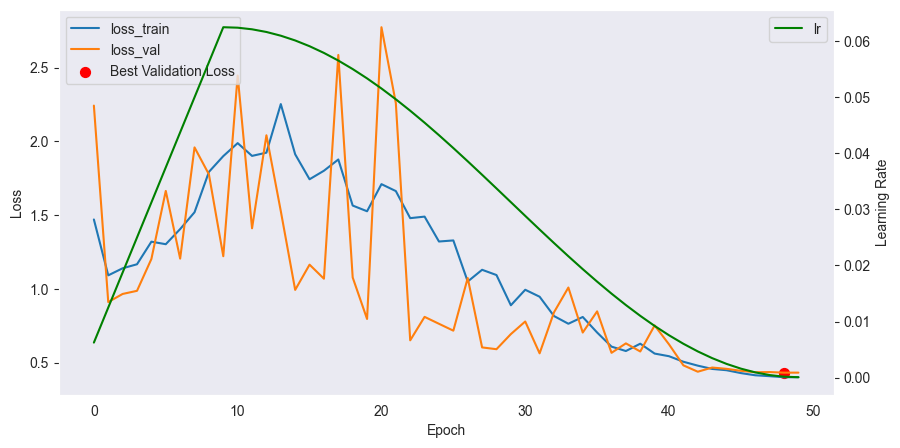

In [136]:
fig, (ax0) = plt.subplots(1,1, figsize=(10,5))
df[["loss_train","loss_val"]].rolling(1).mean().plot(ax=ax0)
ax0.scatter(best_epoch-1, best_val_loss, color='r', marker='.',s=200, label='Best Validation Loss')
ax0.set_ylabel("Loss")
ax0.legend()
plt.ylim(0,2)
ax1 = ax0.twinx()
df.plot(y=['lr'], ax=ax1, color='g')
ax0.legend(loc = 'upper left')
ax1.legend(loc = 'upper right')
ax0.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate")
plt.show()